In [19]:
# Import packages
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import scikitplot
import tarfile
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score
np.random.seed(2)

In [10]:
# ====================================== Load the data =============================================================
data1 = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
data1.columns = ['label', 'text']

def read_label_text(file_name):
    """
    read file contents(text) and put them into data frame
    """
    rows = []
    tar = tarfile.open(file_name, "r:gz")
    for member in tar.getmembers():
        if "ham" in member.name:
                f = tar.extractfile(member)
                if f is not None:
                    row = f.read().splitlines()
                    row = b' '.join(row)
                    row = row.decode(encoding='utf-8', errors='ignore')
                    rows.append({'label': 'ham','text': row})

        if "spam" in member.name:
                f = tar.extractfile(member)
                if f is not None:
                    row = f.read().splitlines()
                    row = b' '.join(row)
                    row = row.decode(encoding='utf-8', errors='ignore')
                    rows.append({'label': 'spam','text': row})
    tar.close()
    return pd.DataFrame(rows)



def read_enron_dataset(file_names):
    """
    read all six files and combine all six data frames to one big data frame
    """
    df = pd.DataFrame()
    for ele in file_names:
        temp = read_label_text(ele)
        df = df.append(temp)
    return df.reset_index(drop = True)

file_names = ["enron1.tar.gz"]

data2 = read_enron_dataset(file_names)

data= pd.concat([data1,data2], axis = 0).reset_index(drop = True)


data.groupby('label').describe()

text                                    
      count unique                     top freq
label                                          
ham    8497   7948  Sorry, I'll call later   30
spam   2247   2116               Subject:    16

In [11]:
# ========================= Customized normalization of text developed by Kenneth ===================================
total_stopwords = set([word.replace("'",'') for word in stopwords.words('english')])
lemma = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = text.replace("'",'') #
    text = re.sub('[^a-zA-Z]',' ',text)
    words = text.split()
    words = [lemma.lemmatize(word) for word in words if (word not in total_stopwords) and (len(word)>1)] # Remove stop words
    text = " ".join(words)
    return text

data['text'] = data['text'].apply(preprocess_text)
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    8497   7639  subject hpl nom march see attached file hplno ...   31
spam   2247   2034                                            subject   19

In [5]:
# ========================= features and labels definition ==========================================================
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(data['text']).toarray()

le = LabelEncoder()
y = le.fit_transform(data['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, shuffle = True, random_state = 2)

print(len(x_train), len(x_test), len(y_train), len(y_test))

9132 1612 9132 1612


In [12]:
# ========================= Random Forest classier starts ===========================================================
classifier=RandomForestClassifier(n_estimators=15,criterion='entropy')
classifier.fit(x_train,y_train)
y_pred=classifier.predict(x_test)
y_pred_rt = classifier.fit(x_train, y_train).predict_proba(x_test)
np.count_nonzero(y_pred)

296

roc_auc for class 1: 0.9929587434523767


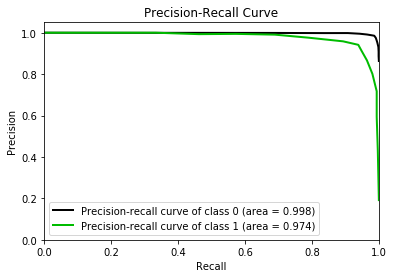

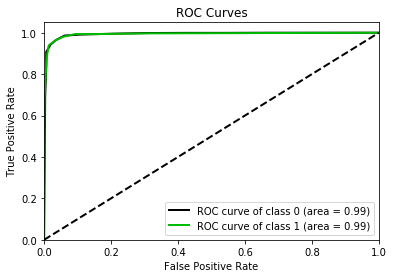

In [13]:
# ========================= precision_recall_curve plotting =========================================================
pr, rc, thresholds = precision_recall_curve(y_test, y_pred_rt[:, 1])
print("roc_auc for class 1:", roc_auc_score(y_test,y_pred_rt[:, 1]))
# Figure 1: precision, recall vs thresholds

scikitplot.metrics.plot_precision_recall(y_test, y_pred_rt, plot_micro = False)
crossover_index = np.max(np.where(pr <= rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]

# Figure 2: ROC
scikitplot.metrics.plot_roc(y_test, y_pred_rt, plot_micro = False, plot_macro = False)

plt.show()

In [18]:
# ========================== classification report and Confusion matrix ============================================
print(classification_report(y_test, y_pred))

m_confusion_test = confusion_matrix(y_test, y_pred)
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1303
           1       0.94      0.90      0.92       309

    accuracy                           0.97      1612
   macro avg       0.96      0.94      0.95      1612
weighted avg       0.97      0.97      0.97      1612



,Predicted 0,Predicted 1
Actual 0,1286,17
Actual 1,30,279
